# EDA

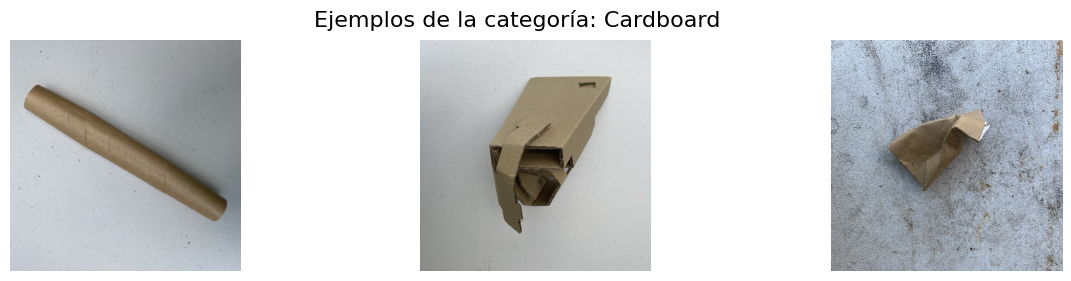

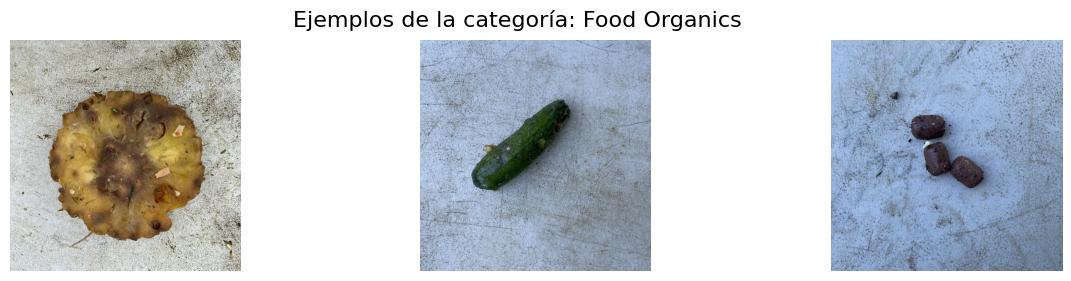

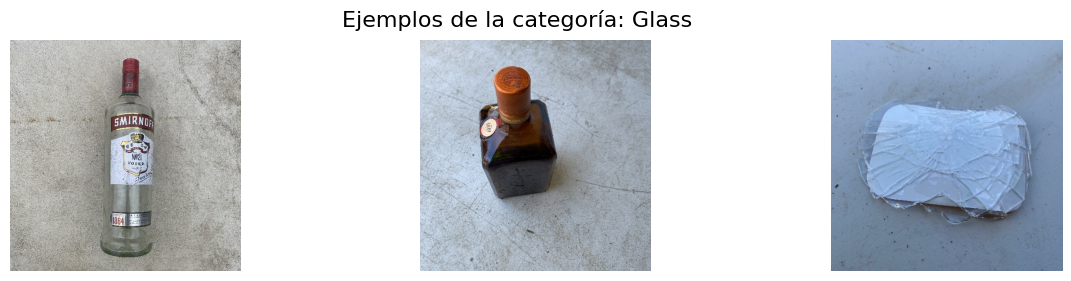

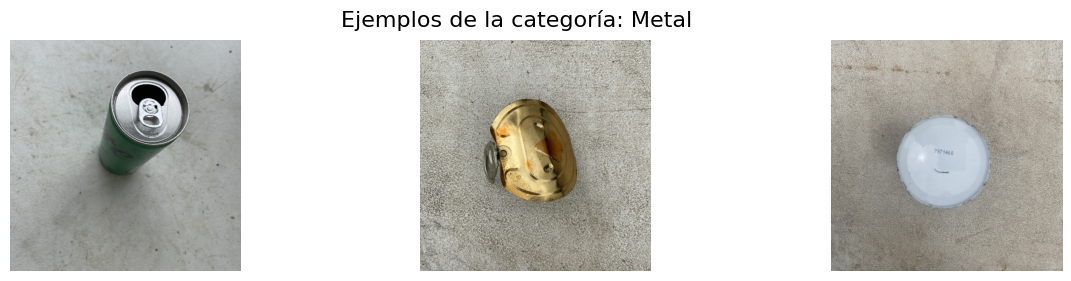

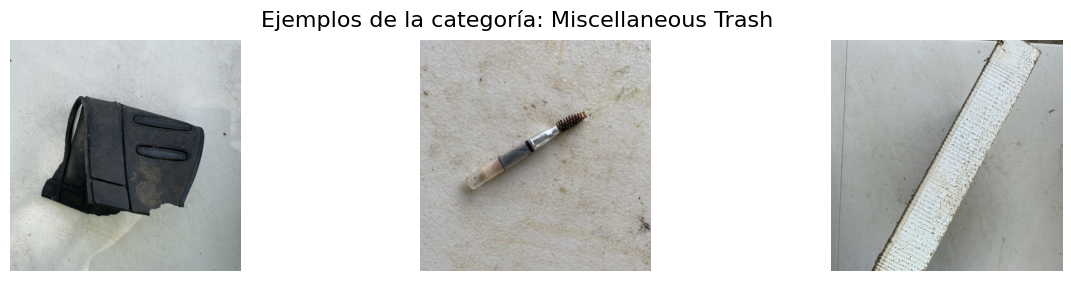

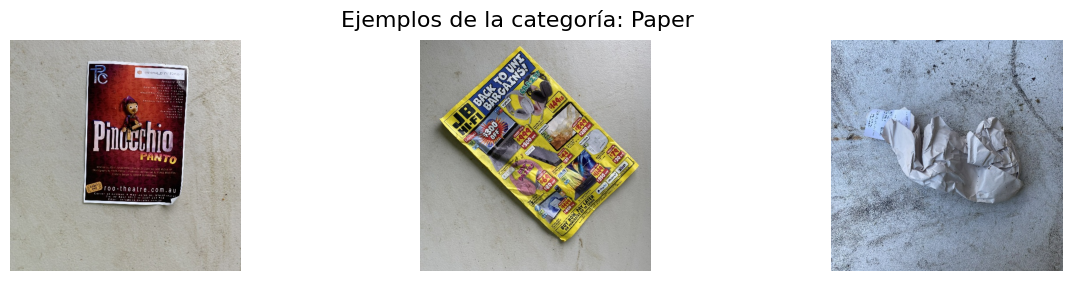

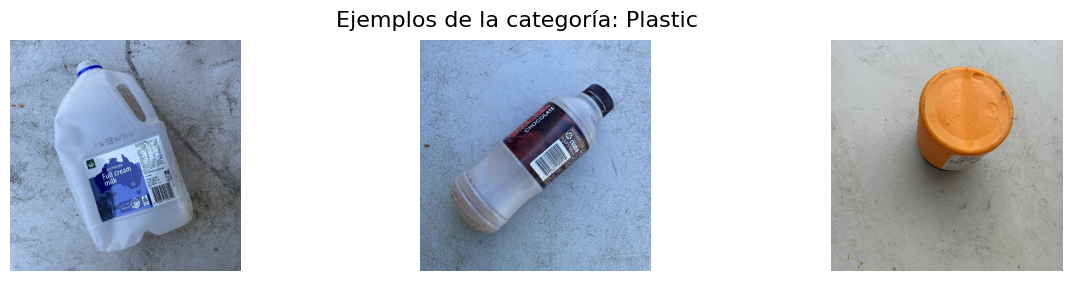

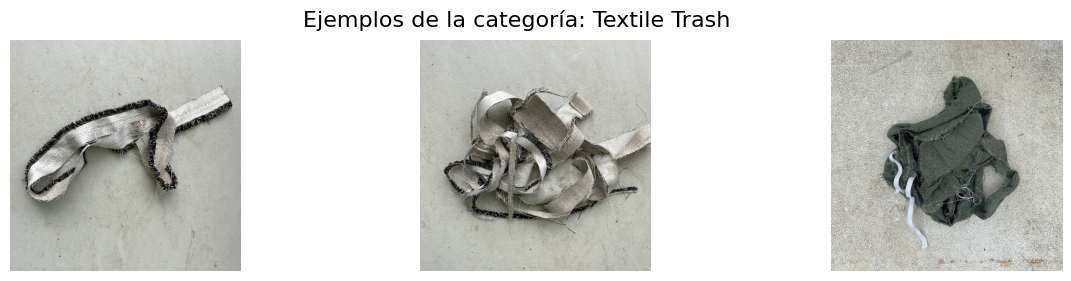

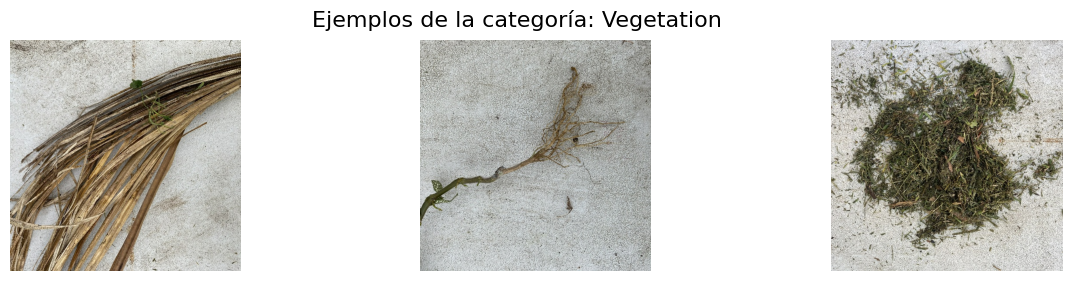

In [45]:
import os
import matplotlib.pyplot as plt
from PIL import Image

categories = ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
dataset_path = './RealWaste'

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    if os.path.exists(folder_path):
        images = os.listdir(folder_path)[:3]
        fig, axs = plt.subplots(1, 3, figsize=(15, 3))
        fig.suptitle(f'Ejemplos de la categoría: {category}', fontsize=16)
        for i, img_name in enumerate(images):
            img_path = os.path.join(folder_path, img_name)
            img = Image.open(img_path)
            axs[i].imshow(img)
            axs[i].axis('off')
        plt.show()
    else:
        print(f'La carpeta para la categoría {category} no existe en la ruta especificada: {folder_path}')


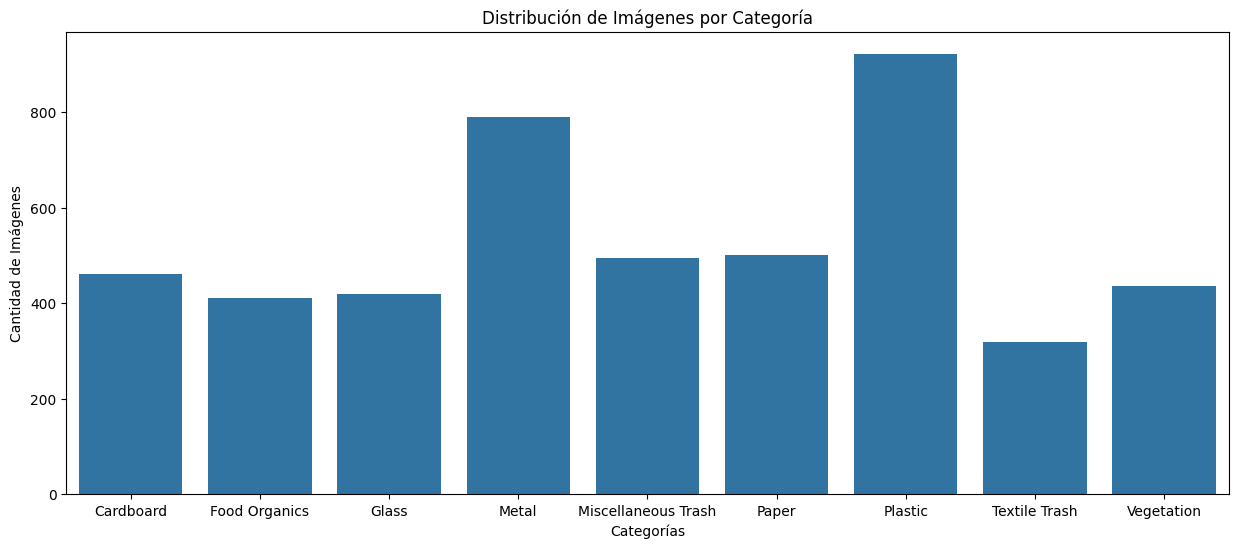

In [59]:
import seaborn as sns

category_counts = {category: len(os.listdir(os.path.join(dataset_path, category))) for category in categories}
plt.figure(figsize=(15, 6))
sns.barplot(x=list(category_counts.keys()), y=list(category_counts.values()))
plt.xlabel('Categorías')
plt.ylabel('Cantidad de Imágenes')
plt.title('Distribución de Imágenes por Categoría')
plt.show()


Se aprecia la diferencia de distribución de imagenes por clase, lo cual podría sesgar el análisis y la aplicación de modelos de ML sobre el dataset, por ende, normalizamos los datos, alcanzando una cantidad mínima común de imagenes en cada dataset, asegurando que cada clase entregue la misma cantidad de información y no se desbalancee el estudio.

In [47]:
import os
import random
from shutil import copyfile

categories = ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
dataset_path = './RealWaste'
output_path = './BalancedRealWaste'
os.makedirs(output_path, exist_ok=True)

In [48]:
# Determinamos la cantidad mínima de imágenes para balancear cada clase
min_images = min([len(os.listdir(os.path.join(dataset_path, category))) for category in categories])
print(f'La cantidad mínima de imágenes en cualquier clase es: {min_images}')

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    images = os.listdir(folder_path)
    sampled_images = random.sample(images, min_images)
    
    # Creamos el nuevo dataset balanceado
    category_output_path = os.path.join(output_path, category)
    os.makedirs(category_output_path, exist_ok=True)
    
    for img_name in sampled_images:
        source_path = os.path.join(folder_path, img_name)
        dest_path = os.path.join(category_output_path, img_name)
        copyfile(source_path, dest_path)

print('Dataset balanceado creado con éxito.')

La cantidad mínima de imágenes en cualquier clase es: 318
Dataset balanceado creado con éxito.


Además, el dataset no contiene un archivo descriptor de las imagenes y sus clases/categorías, por ende, generamos que contendrá la referencia de cada imagen a su categoría correspondiente (incluyendo el uso de LabelEncoder para estas)

In [49]:
import os
import pandas as pd

dataset_path = './BalancedRealWaste/'
categories = os.listdir(dataset_path)

data = []

for category in categories:
    category_path = os.path.join(dataset_path, category)
    if os.path.isdir(category_path):
        for image_name in os.listdir(category_path):
            if image_name.endswith('.jpg') or image_name.endswith('.png'):  # Filtra solo archivos de imagen
                image_path = os.path.join(category_path, image_name)
                data.append([image_name, category])

df = pd.DataFrame(data, columns=['file', 'label'])
df.to_csv('./BalancedRealWaste/realwaste_labels.csv', index=False)


In [50]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Cargar el CSV
df = pd.read_csv('./BalancedRealWaste/realwaste_labels.csv')

# Convertir etiquetas de texto a enteros
label_encoder = LabelEncoder()
df['label_int'] = label_encoder.fit_transform(df['label'])

# Mostrar las primeras filas para verificar
print(df.head())

# Guardar el DataFrame actualizado si es necesario
df.to_csv('./BalancedRealWaste/realwaste_labels.csv', index=False)


                file      label  label_int
0    Cardboard_1.jpg  Cardboard          0
1   Cardboard_10.jpg  Cardboard          0
2  Cardboard_100.jpg  Cardboard          0
3  Cardboard_101.jpg  Cardboard          0
4  Cardboard_102.jpg  Cardboard          0


Finalmente, se genera el archivo 'realwaste_labels.csv' que contendrá la referencia de cada imagen y categoría.

In [51]:
import numpy as np

# Ejemplo de análisis de tamaño
sizes = []
for category in categories:
    folder_path = os.path.join(dataset_path, category)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = Image.open(img_path)
        sizes.append(img.size)

unique_sizes = set(sizes)
print(f'Tamaños únicos de las imágenes: {unique_sizes}')


Tamaños únicos de las imágenes: {(524, 524)}


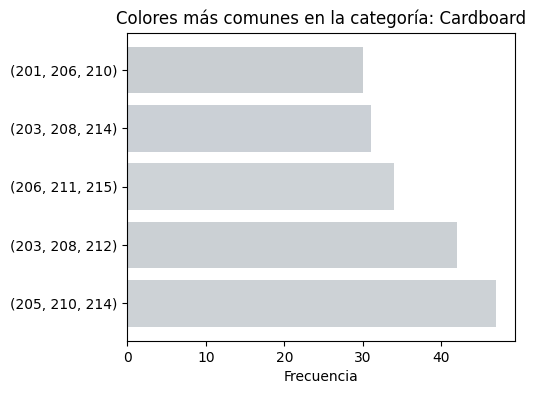

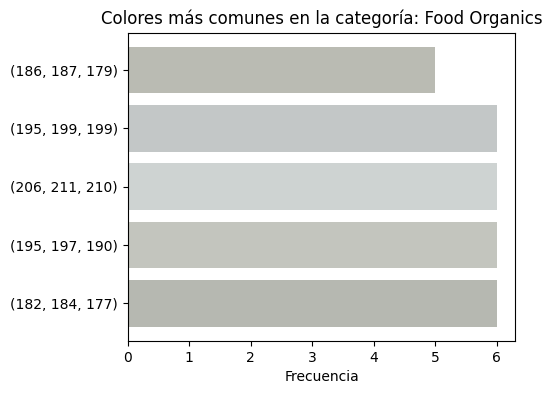

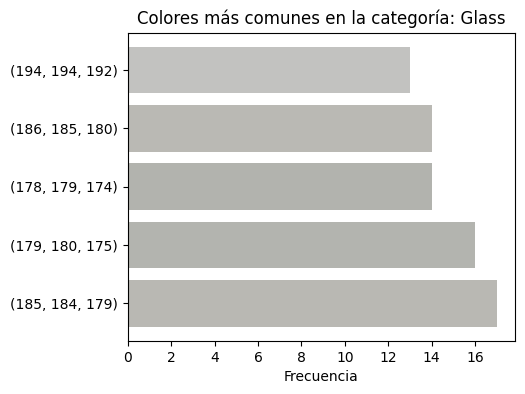

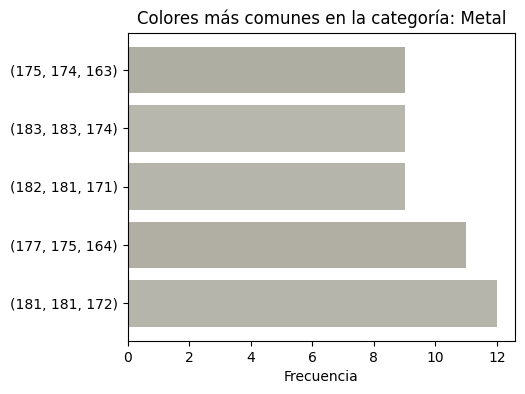

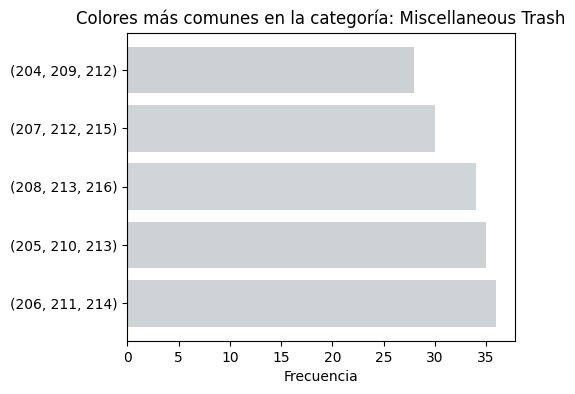

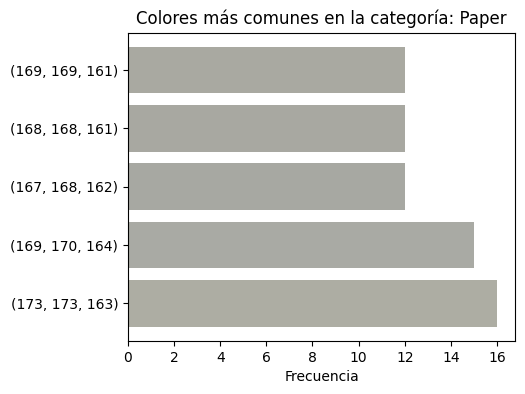

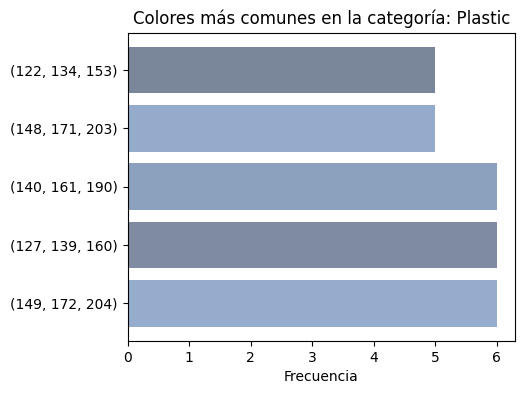

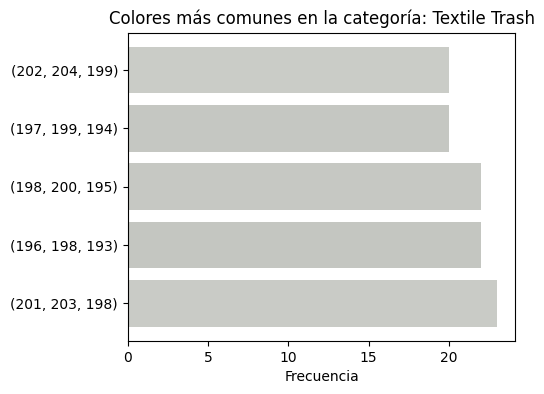

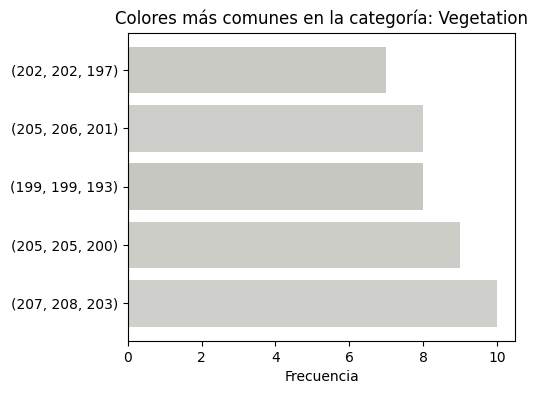

In [52]:
from collections import Counter

def get_colors(image_path, num_colors=5):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((50, 50))  # Redimensiona para simplificar el análisis
    img_array = np.array(img)
    img_array = img_array.reshape((img_array.shape[0] * img_array.shape[1], 3))
    color_counts = Counter(map(tuple, img_array))
    most_common_colors = color_counts.most_common(num_colors)
    return most_common_colors

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    img_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    colors = get_colors(img_path)
    plt.figure(figsize=(5, 4))
    plt.title(f'Colores más comunes en la categoría: {category}')
    for color, count in colors:
        plt.barh(str(color), count, color=np.array(color) / 255)
    plt.xlabel('Frecuencia')
    plt.show()


In [53]:
def calculate_average_rgb(image_path):
    image = Image.open(image_path).convert('RGB')
    image_array = np.array(image)
    return np.mean(image_array, axis=(0, 1))

average_rgb_values = []

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    if os.path.exists(folder_path):
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            avg_rgb = calculate_average_rgb(img_path)
            average_rgb_values.append((category, *avg_rgb))

# Convertir a numpy array para facilitar la manipulación
average_rgb_values = np.array(average_rgb_values, dtype=object)

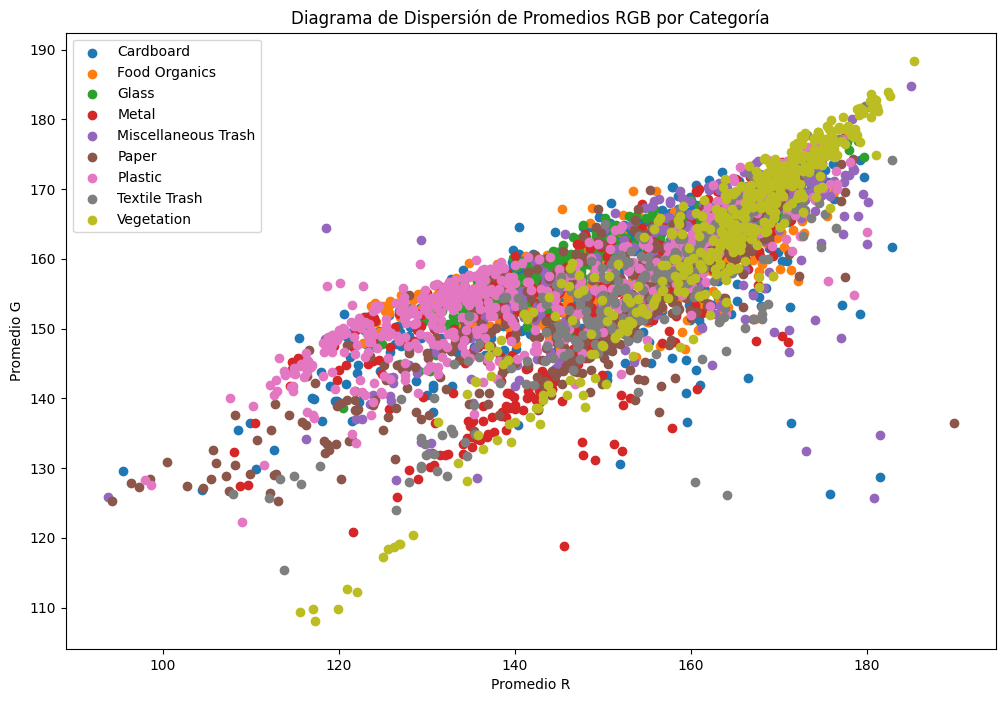

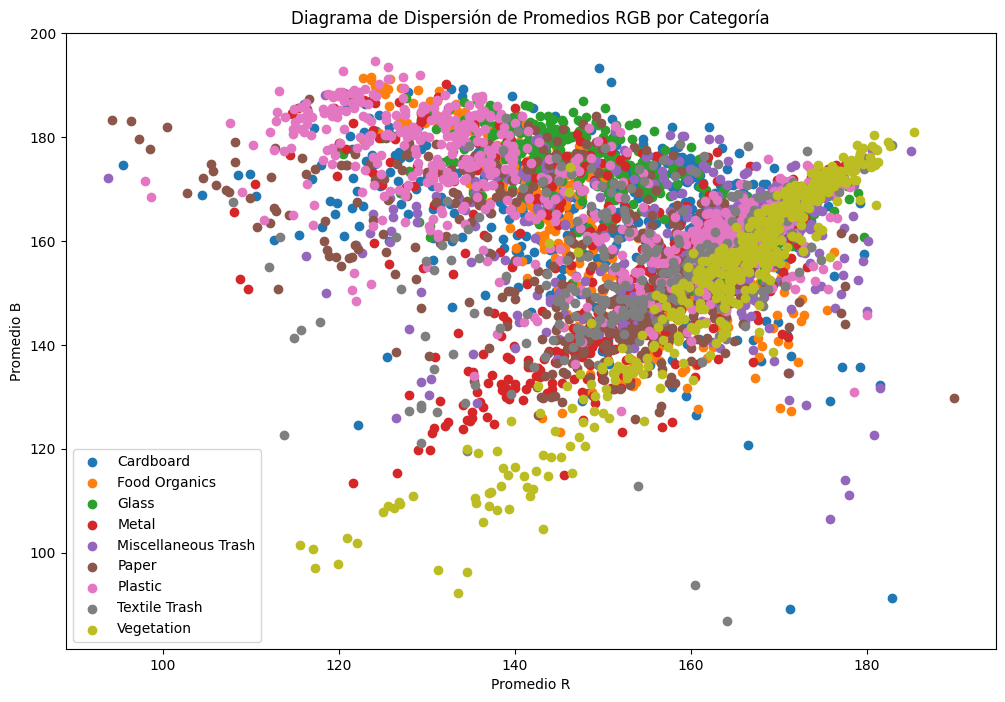

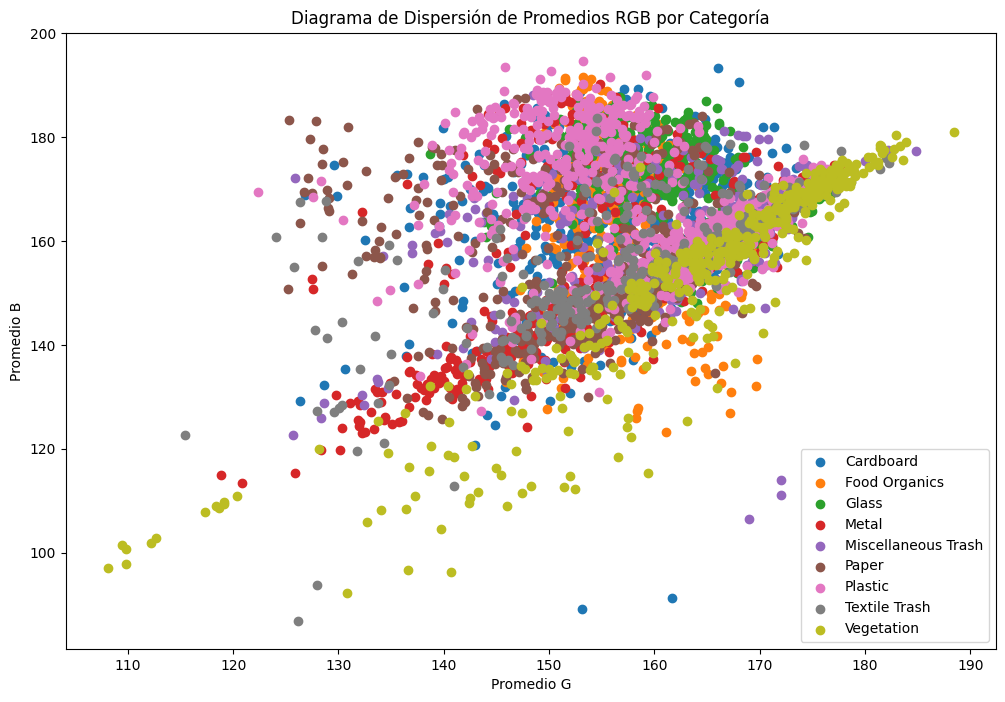

In [54]:
# Crear un DataFrame para facilitar la visualización
import pandas as pd
df = pd.DataFrame(average_rgb_values, columns=['Category', 'Avg_R', 'Avg_G', 'Avg_B'])

# Graficar diagramas de dispersión
plt.figure(figsize=(12, 8))
for category in categories:
    subset = df[df['Category'] == category]
    plt.scatter(subset['Avg_R'], subset['Avg_G'], label=category)

plt.xlabel('Promedio R')
plt.ylabel('Promedio G')
plt.title('Diagrama de Dispersión de Promedios RGB por Categoría')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
for category in categories:
    subset = df[df['Category'] == category]
    plt.scatter(subset['Avg_R'], subset['Avg_B'], label=category)

plt.xlabel('Promedio R')
plt.ylabel('Promedio B')
plt.title('Diagrama de Dispersión de Promedios RGB por Categoría')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
for category in categories:
    subset = df[df['Category'] == category]
    plt.scatter(subset['Avg_G'], subset['Avg_B'], label=category)

plt.xlabel('Promedio G')
plt.ylabel('Promedio B')
plt.title('Diagrama de Dispersión de Promedios RGB por Categoría')
plt.legend()
plt.show()

In [55]:
import pandas as pd
import numpy as np
from PIL import Image
import os

categories = ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
dataset_path = './RealWaste'

def calculate_average_rgb(image_path):
    image = Image.open(image_path).convert('RGB')
    image_array = np.array(image)
    return np.mean(image_array, axis=(0, 1))

average_rgb_values = []

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    if os.path.exists(folder_path):
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            avg_rgb = calculate_average_rgb(img_path)
            average_rgb_values.append((category, *avg_rgb))

# Convertir a numpy array para facilitar la manipulación
average_rgb_values = np.array(average_rgb_values, dtype=object)

# Crear un DataFrame para facilitar la visualización
df = pd.DataFrame(average_rgb_values, columns=['Category', 'Avg_R', 'Avg_G', 'Avg_B'])

# Calcular la tendencia central
central_tendency = df.groupby('Category').mean()
print(central_tendency)


                          Avg_R       Avg_G       Avg_B
Category                                               
Cardboard            149.117601  156.246819  164.478939
Food Organics        150.182904  157.529139   161.59909
Glass                150.175158  160.497657  172.567497
Metal                153.014961  155.704757  155.278802
Miscellaneous Trash  159.981062  161.921487  160.465269
Paper                148.416669  152.585703   155.76881
Plastic              147.678431  157.913695  167.925537
Textile Trash        156.087151  157.159281  156.162911
Vegetation           163.058581  163.131021  152.368267


In [56]:
# Calcular la dispersión
dispersion = df.groupby('Category').std()
print(dispersion)


                         Avg_R      Avg_G      Avg_B
Category                                            
Cardboard            14.640799   8.590593  13.210922
Food Organics        12.428502   4.838469  15.365878
Glass                11.656656   5.917177   8.840629
Metal                13.920474  11.017576  14.955036
Miscellaneous Trash  13.397170   9.780418  10.835539
Paper                16.038832   9.876780  13.505608
Plastic              18.131071   8.929475  11.995512
Textile Trash        13.445970  11.800129  12.948377
Vegetation           13.003671  14.164337  19.316030


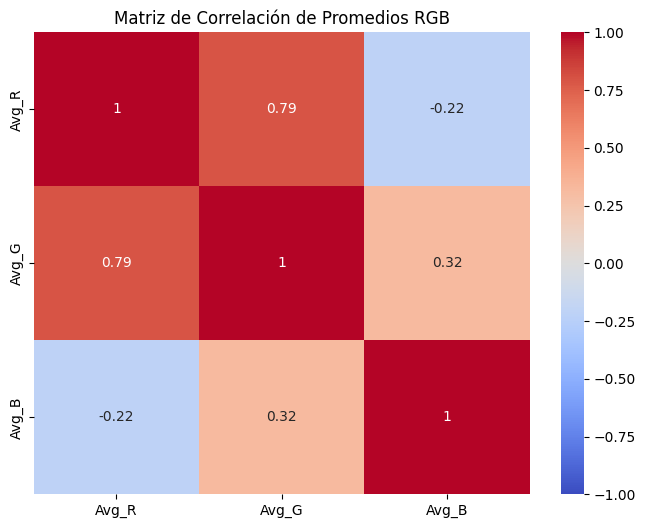

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la correlación entre las variables
correlation_matrix = df[['Avg_R', 'Avg_G', 'Avg_B']].corr()

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación de Promedios RGB')
plt.show()



In [58]:
def detect_outliers(df, columns):
    outliers = {}
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

outliers = detect_outliers(df, ['Avg_R', 'Avg_G', 'Avg_B'])
print(outliers)


{'Avg_R':                  Category       Avg_R       Avg_G       Avg_B
39              Cardboard  108.558432  135.522919  172.766189
80              Cardboard   95.492294  129.592852  174.598512
102             Cardboard  104.456832  126.836002  168.875645
1441                Metal   108.02797  132.254407  165.529161
1551                Metal  108.751293  127.463493  152.637929
1564                Metal  106.380084  134.765416  171.554029
1641                Metal  104.726611  131.849881  166.853523
2301  Miscellaneous Trash   93.740596  125.891429  172.064736
2703                Paper  102.711592  127.468169  169.274077
2872                Paper  105.615148  132.607784  173.517882
2874                Paper  108.171974  137.561699  179.061925
2954                Paper   97.207582  127.265646  179.578816
2956                Paper    94.15155  125.320013   183.32139
2957                Paper  100.497196  130.911922   182.02207
2958                Paper   98.481069  128.490651  177.62599

# No Supervisado